In [128]:
import math

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
error_calculation_metrics = ['mean_squared_error', 'mean_absolute_error']
ecm = error_calculation_metrics[1]
k_fold_value = 5

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

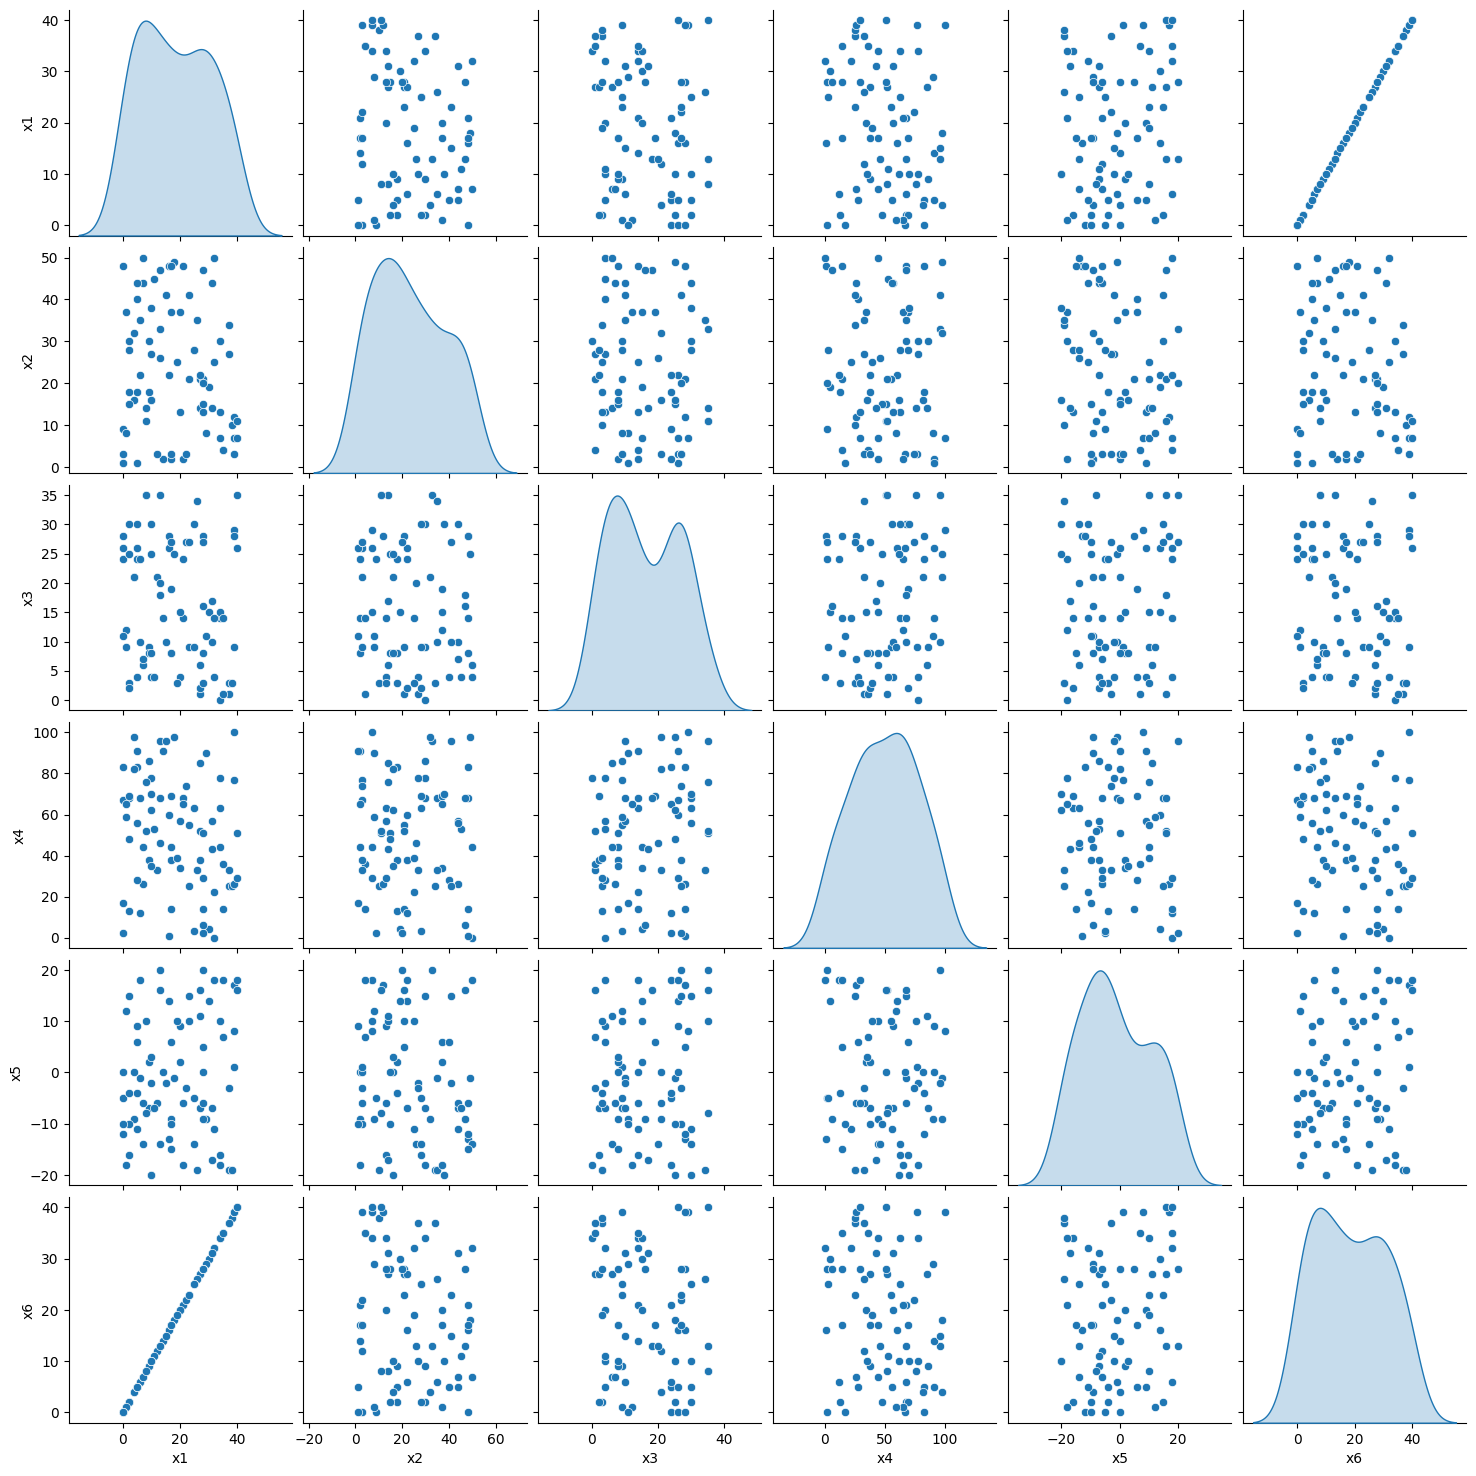

In [129]:
from sklearn.model_selection import KFold

raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

def random_sample(train_fraction):
    train = dataset.sample(frac=train_fraction, random_state=0)
    test = dataset.drop(train.index)
    return train, test

def k_fold_sample(sample_source=dataset):
    kf = KFold(n_splits=k_fold_value, random_state=None, shuffle=False)

    features = np.array(sample_source[predictors])
    labels = np.array(sample_source['Y'])

    k_s = []
    for train_i, test_i in kf.split(dataset):
        k_s.append({'train_features': features[train_i],
                          'train_labels': labels[train_i],
                          'test_features': features[test_i],
                          'test_labels': labels[test_i]})
    return k_s

train_set, test_set = random_sample(train_fraction=0.8)

sns.pairplot(train_set[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']], diag_kind='kde')

From looking at the results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same value twice.

Then, I wanted to see how each of those predictors relate to Y separately.

In [130]:
dataset = dataset.drop('x6', axis=1)
train_set = train_set.drop('x6', axis=1)
test_set = test_set.drop('x6', axis=1)

[<AxesSubplot:xlabel='x1', ylabel='Y'>,
 <AxesSubplot:xlabel='x2', ylabel='Y'>,
 <AxesSubplot:xlabel='x3', ylabel='Y'>,
 <AxesSubplot:xlabel='x4', ylabel='Y'>,
 <AxesSubplot:xlabel='x5', ylabel='Y'>]

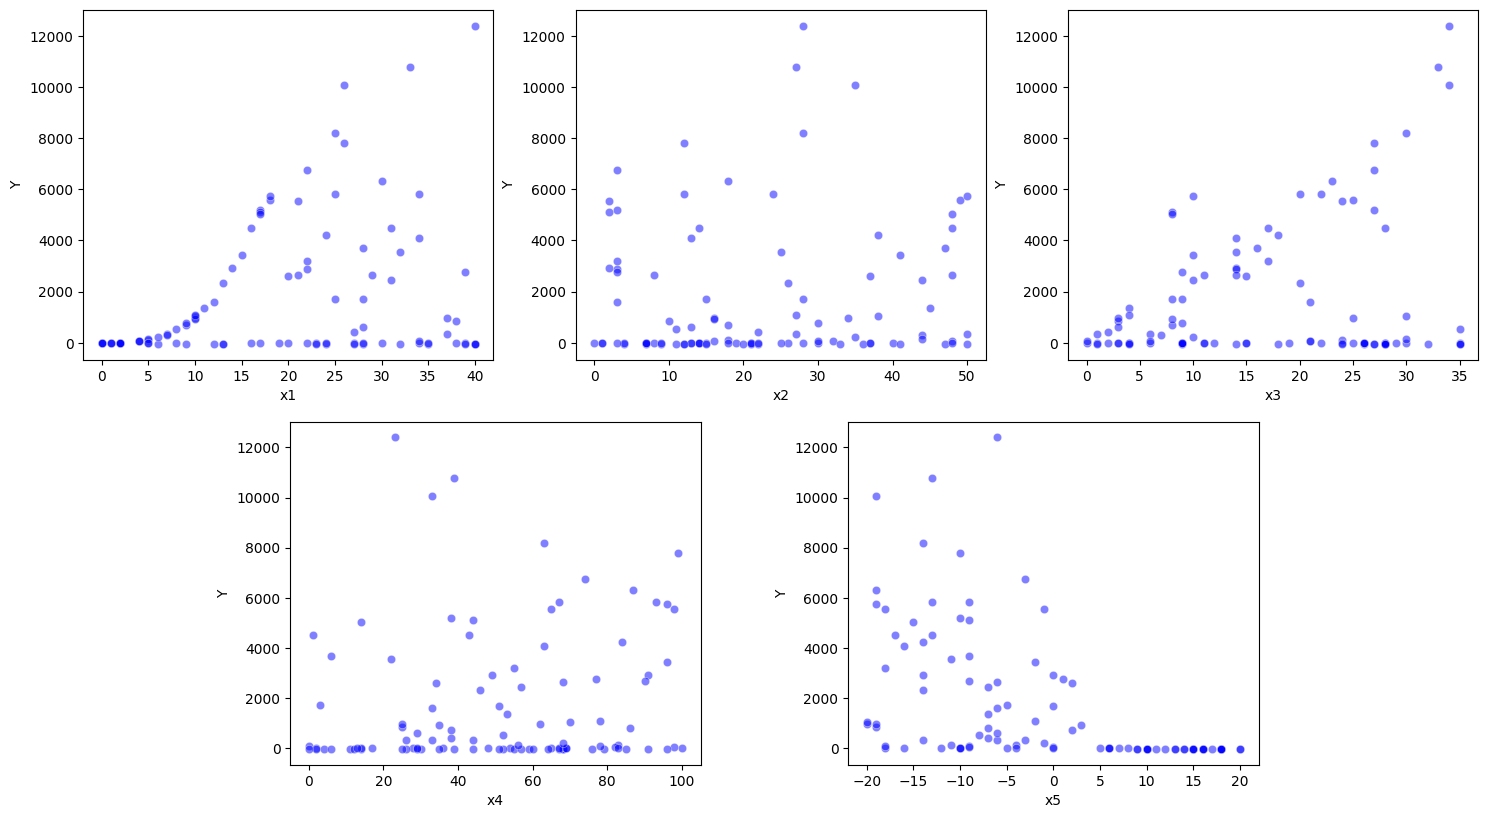

In [131]:
predictors = ['x1', 'x2', 'x3', 'x4', 'x5']

fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])
[sns.scatterplot(ax=axes_[i // 3, i % 3], x=dataset[predictors[i]], y=dataset['Y'], alpha=0.5, color='b')
 for i in range(len(predictors))]

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be low. Similarly,
when x5 has a value greater than 5, its corresponding Y value is very low.

Because of this, I can say that some kind of classification method must be applied without testing any kind of model.

In [132]:
k_samples = k_fold_sample()

train_features = train_set.copy()
test_features = test_set.copy()

train_labels = train_features.pop('Y')
test_labels = test_features.pop('Y')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

,min,max,mean,std
SampleNo,1.0,100.0,50.50,29.011492
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


# I. Single Linear Regression

## I.I. For x1

In [133]:
x1 = np.array(train_features['x1'])
x1_normalizer = layers.Normalization(input_shape=[1, ], axis=None)
x1_normalizer.adapt(x1)

x1_model = tf.keras.Sequential([x1_normalizer, layers.Dense(units=1)])

display(x1_model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_18 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


None

In [134]:
x1_model.predict(x1)
x1_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=ecm)

history = x1_model.fit(x=train_features['x1'],
                       y=train_labels,
                       epochs=200,
                       verbose=0,
                       validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

3/3 [==============================] - 0s 499us/step


,loss,val_loss,epoch
0,1290.439697,1790.287842,0
1,1290.393311,1790.274902,1
2,1290.341187,1790.257080,2
3,1290.296875,1790.246338,3
4,1290.250732,1790.235352,4
...,...,...,...
195,1287.661133,1783.950439,195
196,1287.643433,1783.915527,196
197,1287.638672,1783.878784,197
198,1287.619995,1783.845215,198


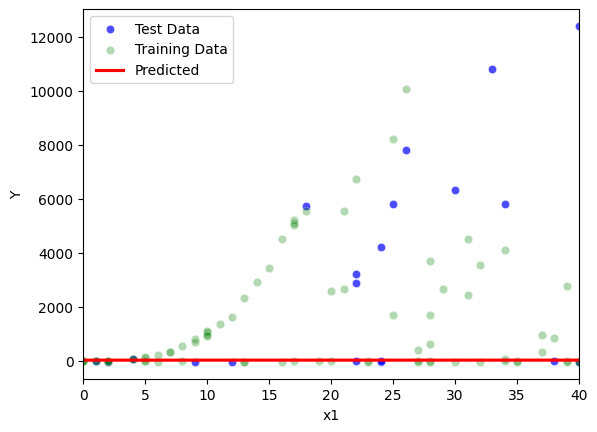

In [135]:
fig, ax = plt.subplots()
ax.set_xlim([table_heuristics['min']['x1'], table_heuristics['max']['x1']])

sns.scatterplot(ax=ax, x=test_features['x1'], y=test_labels,
                alpha=0.7, color='b', label='Test Data')
sns.scatterplot(ax=ax, x=train_features['x1'], y=train_labels,
                alpha=0.3, color='g', label='Training Data')

x = test_features['x1']
y_predict = x1_model.predict(x, verbose=0)

sns.regplot(ax=ax, x=test_features['x1'], y=y_predict[:,0],
            color='r', scatter=False, truncate=False, label='Predicted')

plt.xlabel('x1')
plt.ylabel('Y')
plt.legend()

## I.II. For Every Input Predictor

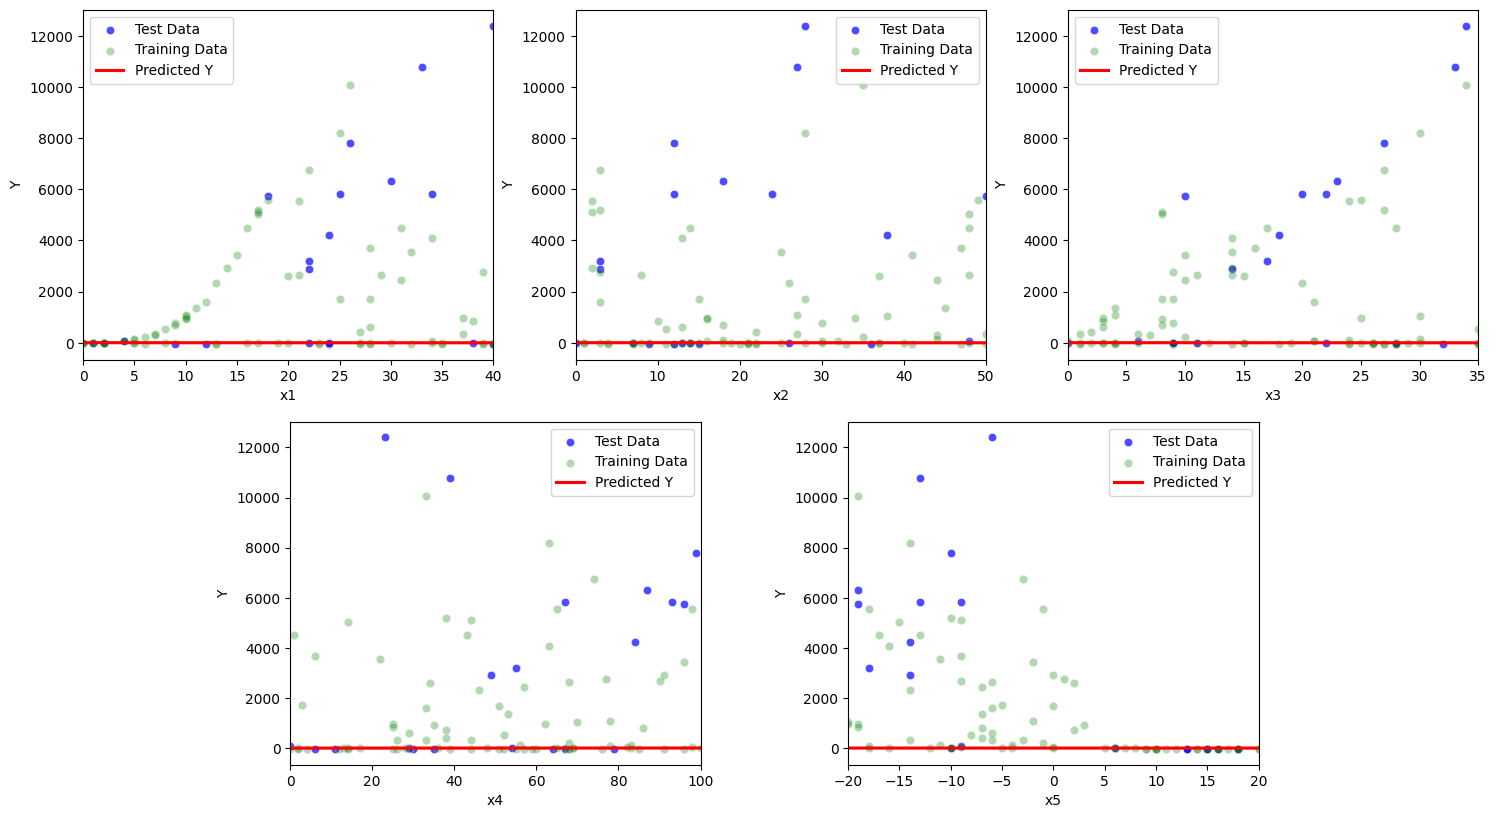

In [136]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

all_test_results = {}

ax_i = 0
xi_normalizer = layers.Normalization(input_shape=[1, ], axis=None)

for p in predictors:
    ax = axes[ax_i // 3, ax_i % 3]

    xi = np.array(train_features[p])
    xi_normalizer.adapt(xi)

    xi_model = tf.keras.Sequential([xi_normalizer, layers.Dense(units=1)])
    xi_model.predict(xi, verbose=0)
    xi_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss=ecm)

    all_test_results[p] = xi_model.evaluate(test_features[p], test_labels, verbose=0)

    x = test_features[p]
    y_predict = xi_model.predict(x, verbose=0)

    sns.scatterplot(ax=ax, x=test_features[p], y=test_labels,
                    alpha=0.7, color='b', label='Test Data')
    sns.scatterplot(ax=ax, x=train_features[p], y=train_labels,
                    alpha=0.3, color='g', label='Training Data')
    sns.regplot(ax=ax, x=x, y=y_predict,
                color='r', scatter=False, label='Predicted Y', truncate=False)
    ax.set_xlim(table_heuristics['min'][p], table_heuristics['max'][p])
    ax.set_xlabel(p)
    ax.set_ylabel('Y')
    ax.legend()
    ax_i += 1

## II. Multiple Linear Regression

In [137]:
mul_linreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1)])

mul_linreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss=ecm)

history = mul_linreg.fit(
    train_features[predictors],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2)

all_test_results['mul_linreg'] = mul_linreg.evaluate(test_features[predictors], test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1301.200317,1796.976562,0
1,1299.742676,1795.781494,1
2,1298.266846,1794.710693,2
3,1297.219971,1793.571777,3
4,1296.088013,1792.577393,4
...,...,...,...
995,1125.692627,1576.487305,995
996,1125.666138,1576.431885,996
997,1125.689941,1576.442627,997
998,1125.581299,1576.316650,998


In [138]:
def display_error_table():
    display(pd.DataFrame([[k, v] for k,v in all_test_results.items()], columns=['model', ecm]))

display_error_table()

,model,mean_absolute_error
0,x1,3265.076172
1,x2,3265.157959
2,x3,3265.202148
3,x4,3264.438965
4,x5,3264.360107
5,mul_linreg,2937.436279


# III. Polynomial Regression

## III.I. Second Order Polynomial

In [139]:
sec_order_polyreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1, input_shape=[3])])

sec_order_polyreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss=ecm)

history = sec_order_polyreg.fit(
    train_features[predictors],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2)

all_test_results['sec_order_polyreg'] = sec_order_polyreg.evaluate(test_features[predictors], test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1348.078857,1838.731323,0
1,1343.717651,1834.680420,1
2,1339.660889,1830.623779,2
3,1335.454102,1826.600586,3
4,1331.226807,1822.581543,4
...,...,...,...
995,1123.568848,1570.942139,995
996,1123.514282,1570.812744,996
997,1123.592163,1570.593628,997
998,1123.468506,1570.492432,998


## III.II. Third Order Polynomial

In [140]:
thr_order_polyreg = tf.keras.Sequential([tf.keras.layers.Normalization(axis=-1), layers.Dense(units=1, input_shape=[4])])

thr_order_polyreg.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss=ecm)

history = thr_order_polyreg.fit(
    train_features[predictors],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split=0.2)

all_test_results['thr_order_polyreg'] = thr_order_polyreg.evaluate(test_features[predictors], test_labels, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist)

,loss,val_loss,epoch
0,1284.381958,1780.839844,0
1,1283.902466,1780.182373,1
2,1283.308350,1779.826660,2
3,1282.805420,1779.393188,3
4,1282.329834,1778.920776,4
...,...,...,...
995,1125.185669,1574.288696,995
996,1125.144775,1574.138184,996
997,1125.113647,1574.047363,997
998,1125.077393,1573.953369,998


In [141]:
display_error_table()

,model,mean_absolute_error
0,x1,3265.076172
1,x2,3265.157959
2,x3,3265.202148
3,x4,3264.438965
4,x5,3264.360107
5,mul_linreg,2937.436279
6,sec_order_polyreg,2930.524658
7,thr_order_polyreg,2934.082764


In [142]:
def k_nearest_regression(k=3):

    def euclidean_dist(p_x, p_y):
        distances = list(map(lambda pr: (p_x[pr] - p_y[pr]) ** 2, predictors))
        return sum(distances)

    predictions = []

    for i in range(len(test_features.index)):
        current_row = test_features.iloc[i]
        current_distances = [[train_labels.iloc[n], euclidean_dist(current_row, train_features.iloc[n])]
                             for n in range(len(train_features.index))]
        current_distances.sort(key=lambda n: n[1])
        k_nearest_avg = sum([n[0] for n in current_distances[:k]]) // k
        predictions.append(k_nearest_avg)

    y_comparison = {'actual': list(test_labels), 'predicted': predictions}

    k_error = 0
    for act, pred in zip(y_comparison['actual'], y_comparison['predicted']):
        k_error += abs(act - pred)

    return {'k': k, 'comparison': pd.DataFrame(y_comparison).transpose(), 'error': k_error/len(predictions)}

## IV. K-Nearest-Neighbor

In [143]:
knn_args = [2, 3, 4, 5]

k_nearest_results = [k_nearest_regression(k) for k in knn_args]
for knn_result in k_nearest_results:
    all_test_results[f'knn_(k={knn_result["k"]})'] = knn_result['error']

display_error_table()

,model,mean_absolute_error
0,x1,3265.076172
1,x2,3265.157959
2,x3,3265.202148
3,x4,3264.438965
4,x5,3264.360107
5,mul_linreg,2937.436279
6,sec_order_polyreg,2930.524658
7,thr_order_polyreg,2934.082764
8,knn_(k=2),2036.300000
9,knn_(k=3),1903.650000


# TESTING

In [144]:
from sklearn.linear_model import LogisticRegression

def calculate_mae(y_act, y_pred):
    test_error = 0
    for actual, predicted in zip(y_act, y_pred):
        test_error += abs(actual - predicted)
    return test_error/len(y_pred)

def calculate_rmse(y_act, y_pred):
    return np.sqrt(((y_act - y_pred) ** 2).sum()/len(predictions))

def log_reg():
    logistic_regression = LogisticRegression(max_iter=20000)
    logistic_regression.fit(train_features[predictors], train_labels)
    
    predictions = logistic_regression.predict(test_features[predictors])
    mae_error = calculate_mae(list(test_labels), predictions)

    y_comparison = {'actual': list(test_labels), 'predicted': predictions}
    return {'comparison': pd.DataFrame(y_comparison), 'error': mae_error}

results = log_reg()
display(results['comparison'].transpose())
all_test_results['log_reg'] = results['error']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
actual,-13.0,4222.0,-37.0,-32.0,-33.0,2897.0,65.0,-25.0,-29.0,7804.0,10792.0,6315.0,5817.0,-25.0,-39.0,1.0,5812.0,12402.0,5733.0,3204.0
predicted,-18.0,5564.0,-33.0,-31.0,-19.0,5114.0,319.0,-19.0,-19.0,2667.0,10077.0,2667.0,4092.0,932.0,-35.0,0.0,2667.0,-35.0,789.0,5552.0


In [145]:
display_error_table()

,model,mean_absolute_error
0,x1,3265.076172
1,x2,3265.157959
2,x3,3265.202148
3,x4,3264.438965
4,x5,3264.360107
5,mul_linreg,2937.436279
6,sec_order_polyreg,2930.524658
7,thr_order_polyreg,2934.082764
8,knn_(k=2),2036.300000
9,knn_(k=3),1903.650000


In [146]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def polynomial_regression(order=2):
    poly_features = PolynomialFeatures(degree=order, include_bias=False)
    poly_train_features = poly_features.fit_transform(train_features[predictors])

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_train_features, train_labels)

    predictions = poly_reg_model.predict(poly_features.fit_transform(test_features[predictors]))

    mae_error = calculate_mae(list(test_labels), predictions)
    print(mae_error)

polynomial_regression(order=2)

1432.1452611683112


In [147]:
k_mae_avg = 0
k_rmse_avg = 0

for i in range(len(k_samples)):

    lin_reg = LinearRegression().fit(k_samples[i]['train_features'], k_samples[i]['train_labels'])
    predictions = lin_reg.predict(k_samples[i]['test_features'])

    k_rmse_avg += calculate_rmse(y_act=k_samples[i]['test_labels'], y_pred=predictions)
    k_mae_avg += calculate_mae(y_act=k_samples[i]['test_labels'], y_pred=predictions)

print(k_rmse_avg/len(k_samples))
print(k_mae_avg/len(k_samples))

2003.6958764921333
1511.9176317821639


In [148]:
from sklearn.preprocessing import StandardScaler, normalize
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization

scaled_data = StandardScaler().fit_transform(dataset[predictors])
x_normalized = normalize(scaled_data, norm='l1', axis=0)
dataset_normalized = pd.DataFrame(x_normalized, columns=predictors)

dataset_normalized['Y'] = dataset['Y']
k_samples_norm = k_fold_sample(dataset_normalized)

In [150]:
k_mae_avg = 0
k_rmse_avg = 0

for i in range(len(k_samples_norm)):

    lin_reg = LinearRegression().fit(k_samples_norm[i]['train_features'], k_samples_norm[i]['train_labels'])
    predictions = lin_reg.predict(k_samples_norm[i]['test_features'])

    k_rmse_avg += calculate_rmse(y_act=k_samples_norm[i]['test_labels'], y_pred=predictions)
    k_mae_avg += calculate_mae(y_act=k_samples_norm[i]['test_labels'], y_pred=predictions)

print(k_rmse_avg/len(k_samples))
print(k_mae_avg/len(k_samples))

2003.6958764921328
1511.9176317821637
